In [ ]:
import subprocess
import json
import pickle

DEFAULT_ATTRIBUTES = (
    'index',
    'uuid',
    'name',
    'timestamp',
    'memory.total',
    'memory.free',
    'memory.used',
    'utilization.gpu',
    'utilization.memory'
)

def get_gpu_info(nvidia_smi_path='nvidia-smi', keys=DEFAULT_ATTRIBUTES, no_units=True):
    nu_opt = '' if not no_units else ',nounits'
    cmd = '%s --query-gpu=%s --format=csv,noheader%s' % (nvidia_smi_path, ','.join(keys), nu_opt)
    output = subprocess.check_output(cmd, shell=True)
    lines = output.decode().split('\n')
    lines = [ line.strip() for line in lines if line.strip() != '' ]

    return [ { k: v for k, v in zip(keys, line.split(', ')) } for line in lines ]


import pprint
pprint.pprint(get_gpu_info())

[{'index': '0',
  'memory.free': '16160',
  'memory.total': '16160',
  'memory.used': '0',
  'name': 'Tesla V100-SXM2-16GB',
  'timestamp': '2021/03/16 06:19:51.214',
  'utilization.gpu': '0',
  'utilization.memory': '0',
  'uuid': 'GPU-0320b09c-0db2-b8ac-456d-bdeb7109531e'}]


# Pip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/kaggle/kaggle-ranzcr

/content/drive/MyDrive/kaggle/kaggle-ranzcr


In [ ]:
!pip -q install adabelief-pytorch==0.2.0
!pip -q install albumentations==0.5.2

     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 37.6MB 116kB/s 
     |████████████████████████████████| 952kB 67.4MB/s 


In [ ]:
!pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [ ]:
!pip -q install mmcv

     |████████████████████████████████| 235kB 14.7MB/s 
     |████████████████████████████████| 194kB 31.7MB/s 


In [ ]:
!pip -q install adamp

In [ ]:
!pip install timm

     |████████████████████████████████| 296kB 14.2MB/s 


# CFG

In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = 'stage_0_trained/exp79_ranzcr_tf_efficientnet_b1_ns_channel1_HAug_bs16_gradual_896_epo12/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = './NIH_Chest_X_rays_ALL_Ture_JPG'

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    print_freq=100
    num_workers=4
    model_name='tf_efficientnet_b1_ns'#'regnety_032'#'inception_resnet_v2'#'regnety_080'#resnest101e,resnest200e,resnest269e
    size=830
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','MultiStepLR']

    epochs=12 #freeze_epo + warmup_epo + cosine_epo
    T_max=12 # CosineAnnealingLR cosine_epo
    warmup_epo = 2
    T_0=5 # CosineAnnealingWarmRestarts
    lr=1e-4 # 5e-4 #<=======================================
    min_lr=1e-6#1e-7
    batch_size=16# 64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=416
    target_size=11
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]
    train=True
    

# Import

In [ ]:
import sys
sys.path.append('./pytorch-image-models-master')

import timm
import ast
import copy
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau,StepLR,MultiStepLR

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

if CFG.device == 'TPU':
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

from adamp import AdamP
import mmcv
import torch_optimizer as optim

from warmup_scheduler import GradualWarmupScheduler  

In [ ]:
# Fix Warmup Bug
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [ ]:
from collections import OrderedDict
# new_state_dict = OrderedDict()
def fix_model_state_dict(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k
        if name.startswith('backbone.'):
            name = name[9:]  # remove 'module.' of dataparallel
        new_state_dict[name] = v
    return new_state_dict


# Data Loading

In [ ]:
train = pd.read_csv('./train.csv')
folds = pd.read_csv('./train_folds.csv')
train_annotations = pd.read_csv('./train_annotations.csv')

# Dataset

In [ ]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}.jpg'
        # image = cv2.imread(file_path)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        image = image.float()
        label = torch.tensor(self.labels[idx]).float()
        return image, label

# Transforms

In [ ]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
#             ToGray(),
            # Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            # HorizontalFlip(p=0.5),
            # RandomBrightnessContrast(p=0.1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1)),
            # HueSaturationValue(p=0.1, hue_shift_limit=0.1, sat_shift_limit=0.1, val_shift_limit=0.1),
            ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=5, border_mode=cv2.BORDER_CONSTANT, p=0.75),
            # Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0.), num_holes=200),
            Normalize(
                mean=(0.5069),
                std=(0.2378),
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=(0.5069),
                std=(0.2378),
            ),
            ToTensorV2(),

        ])



# DO

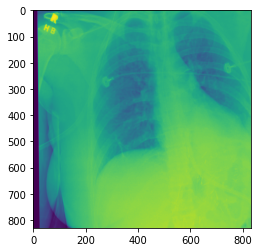

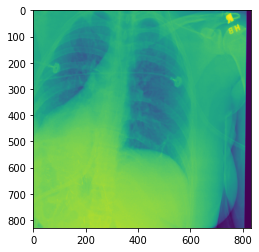

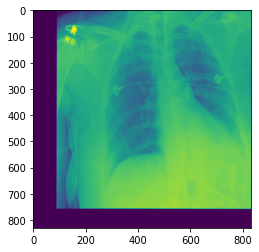

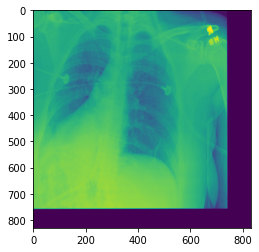

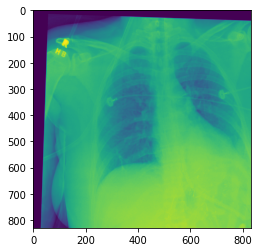

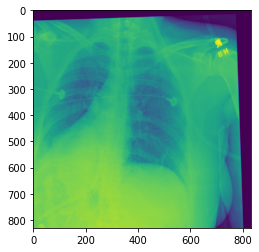

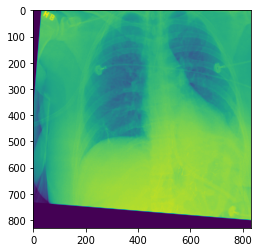

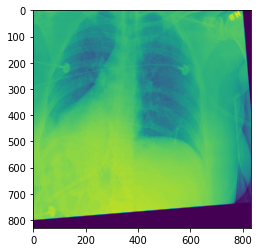

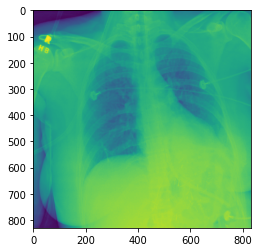

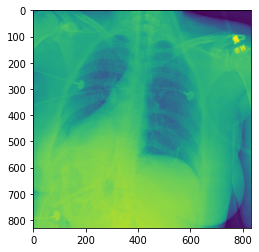

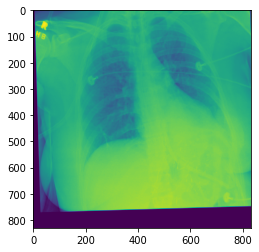

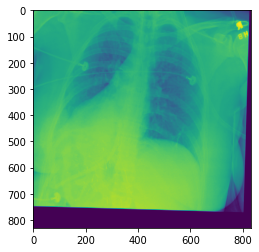

In [ ]:
tta=6
for i in range(tta):
  train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
  image, label = train_dataset[0]
  plt.imshow(image[0])
  plt.show() 
  plt.imshow(image[0].flip(-1))
  plt.show() 
  print('=================================')

torch.Size([2048, 2500])


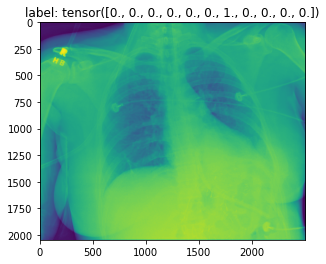

In [ ]:
from matplotlib import pyplot as plt

train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    print(image[0].shape)
    plt.imshow(image[0])
    # plt.imshow(image[0].squeeze().permute(1,2,0))
    plt.title(f'label: {label}')
    plt.show() 

# MODEL

In [ ]:
class SErexnext50(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model('seresnext50_32x4d', pretrained=True)
        self.backbone.fc = nn.Linear(2048, 11)

    def forward(self, x):
        x = self.backbone(x)
        return x


In [ ]:
class Resnest200e(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model(CFG.model_name, pretrained=True)
        self.backbone.fc = nn.Linear(2048, 11)


    def forward(self, x):
        x = self.backbone(x)
        return x


In [ ]:
class Regnety(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model(CFG.model_name, pretrained=True)
        self.backbone.head.fc = nn.Linear(2016, 11)#<==========================


    def forward(self, x):
        x = self.backbone(x)
        return x


In [ ]:
class Regnety_032(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model(CFG.model_name, pretrained=True)
        self.backbone.head.fc = nn.Linear(1512, 11)#<==========================


    def forward(self, x):
        x = self.backbone(x)
        return x


In [ ]:
class InceptionResnetV2(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model(CFG.model_name, pretrained=True)
        self.backbone.classif = nn.Linear(1536, 11)#<==========================


    def forward(self, x):
        x = self.backbone(x)
        return x


In [ ]:
# # import timm

# class FastDenseNet161_(nn.Module):
#     def __init__(self):
#         super(FastDenseNet161_, self).__init__()
#         # self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=1, bias=False)
#         # self.conv2 = nn.Conv2d(8, 8, kernel_size=5, stride=2, bias=False)
#         # self.conv3 = nn.Conv2d(8, 8, kernel_size=5, stride=1, bias=False)
#         # self.conv4 = nn.Conv2d(8, 3, kernel_size=5, stride=2, bias=False)
#         # self.mybn1 = nn.BatchNorm2d(8)
#         # self.mybn2 = nn.BatchNorm2d(8)
#         # self.mybn3 = nn.BatchNorm2d(8)
#         # self.mybn4 = nn.BatchNorm2d(3)

#         self.enet = create_cnn_model(models.densenet161, 11, True)
# #         self.enet[-1] = nn.Identity()
        
# #         self.pooling = nn.AdaptiveAvgPool2d(1)#<=====
# #         self.fc = nn.Linear(2208, 11)
        


#     def extract(self, x):
#         # x = F.relu6(self.mybn1(self.conv1(x)))
#         # x = F.relu6(self.mybn2(self.conv2(x)))
#         # x = F.relu6(self.mybn3(self.conv3(x)))
#         # x = F.relu6(self.mybn4(self.conv4(x)))
#         x = self.enet(x)
#         return x

#     def forward(self, x):
# #         bs = x.size(0)
#         x = self.extract(x)
# #         features = self.enet(x)
# #         features = self.model(x)
# #         pooled_features = self.pooling(features).view(bs, -1)
# #         output = self.fc(pooled_features)
#         return x

In [ ]:
class Efficientnet_b1(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model('tf_efficientnet_b1_ns', pretrained=True)
        self.backbone.classifier = nn.Linear(1280, 11)#<==========================


    def forward(self, x):
        x = self.backbone(x)
        return x


In [ ]:
class Efficientnet_b2(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model('tf_efficientnet_b2_ns', pretrained=True)
        self.backbone.classifier = nn.Linear(1408, 11)#<==========================


    def forward(self, x):
        x = self.backbone(x)
        return x


In [ ]:
class Efficientnet_b4(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model('tf_efficientnet_b4_ns', pretrained=True)
        self.backbone.classifier = nn.Linear(1792, 11)#<==========================


    def forward(self, x):
        x = self.backbone(x)
        return x

In [ ]:
class Efficientnet_b5(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model('tf_efficientnet_b5_ns', pretrained=True)
        self.backbone.classifier = nn.Linear(2048, 11)#<==========================


    def forward(self, x):
        x = self.backbone(x)
        return x


In [ ]:
class Efficientnet_b6(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model('tf_efficientnet_b6_ns', pretrained=True)
        self.backbone.classifier = nn.Linear(2304, 11)#<==========================


    def forward(self, x):
        x = self.backbone(x)
        return x


In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
model = Efficientnet_b1()
    
para = get_n_params(model)/1000000
print(f'{para}M') # 14.9M (Ours) / 15M(Paper)

6.527275M


# LOSS

In [ ]:
class FocalLoss_(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
               ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss

        return loss.sum(dim=1).mean()
    
class FbetaLoss(nn.Module):
    def __init__(self, beta=1):
        super(FbetaLoss, self).__init__()
        self.small_value = 1e-6
        self.beta = beta

    def forward(self, logits, labels):
        beta = self.beta
        batch_size = logits.size()[0]
        p = F.sigmoid(logits)
        l = labels
        num_pos = torch.sum(p, 1) + self.small_value
        num_pos_hat = torch.sum(l, 1) + self.small_value
        tp = torch.sum(l * p, 1)
        precise = tp / num_pos
        recall = tp / num_pos_hat
        fs = (1 + beta * beta) * precise * recall / (beta * beta * precise + recall + self.small_value)
        loss = fs.sum() / batch_size
        return 1 - loss

class CombineLoss(nn.Module):
    def __init__(self):
        super(CombineLoss, self).__init__()
        self.fbeta_loss = FbetaLoss(beta=2)
        self.focal_loss = FocalLoss_()
        
    def forward(self, logits, labels):
        loss_beta = self.fbeta_loss(logits, labels)
        loss_focal = self.focal_loss(logits, labels)
        return 0.5 * loss_beta + 0.5 * loss_focal

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import mmcv
# from .utils import weight_reduce_loss
# from ..registry import LOSSES
# from .cross_entropy_loss import cross_entropy, _expand_binary_labels, binary_cross_entropy, partial_cross_entropy
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.nn import Parameter
from sklearn.manifold import TSNE

# Helper functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.device == 'GPU':
            with autocast():
                y_preds = model(images)
                
                # loss = lsep_loss_stable(y_preds, labels)
                loss = criterion(y_preds, labels)#<====================================
                # record loss
                losses.update(loss.item(), batch_size)
                if CFG.gradient_accumulation_steps > 1:
                    loss = loss / CFG.gradient_accumulation_steps
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
                if (step + 1) % CFG.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    global_step += 1

                # ############
                # if (step + 1) % 2000 == 0:
                #   scheduler.step()
                # ############
        elif CFG.device == 'TPU':
            _, _, y_preds = model(images)
            loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.gradient_accumulation_steps > 1:
                loss = loss / CFG.gradient_accumulation_steps
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.gradient_accumulation_steps == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
                global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.6f}  '
                      .format(
                       epoch+1, step, len(train_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(train_loader)),
                       grad_norm=grad_norm,
                       lr=scheduler.get_lr()[0],
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                xm.master_print('Epoch: [{0}][{1}/{2}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                'Grad: {grad_norm:.4f}  '
                                #'LR: {lr:.6f}  '
                                .format(
                                epoch+1, step, len(train_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(train_loader)),
                                grad_norm=grad_norm,
                                #lr=scheduler.get_lr()[0],
                                ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)#<========================================    
        # loss = lsep_loss_stable(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      .format(
                       step, len(valid_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(valid_loader)),
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                xm.master_print('EVAL: [{0}/{1}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                .format(
                                step, len(valid_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(valid_loader)),
                                ))
    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

In [ ]:
# x = torch.ones((1,1,224,224))

# Train loop

In [ ]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    if CFG.device == 'GPU':
        LOGGER.info(f"========== fold: {fold} training ==========")
    elif CFG.device == 'TPU':
        if CFG.nprocs == 1:
            LOGGER.info(f"========== fold: {fold} training ==========")
        elif CFG.nprocs == 8:
            xm.master_print(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    if CFG.debug:
      train_folds = train_folds.sample(n=200, random_state=CFG.seed).reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))#get_transforms(data='valid')



    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, 
                                  batch_size=CFG.batch_size, 
                                  shuffle=True, 
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, 
                                  batch_size=CFG.batch_size * 2, 
                                  shuffle=False, 
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset,
                                                                        num_replicas=xm.xrt_world_size(),
                                                                        rank=xm.get_ordinal(),
                                                                        shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=CFG.batch_size,
                                                   sampler=train_sampler,
                                                   drop_last=True,
                                                   num_workers=CFG.num_workers)
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset,
                                                                        num_replicas=xm.xrt_world_size(),
                                                                        rank=xm.get_ordinal(),
                                                                        shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                   batch_size=CFG.batch_size * 2,
                                                   sampler=valid_sampler,
                                                   drop_last=False,
                                                   num_workers=CFG.num_workers)

    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    if CFG.device == 'TPU':
        device = xm.xla_device()
    elif CFG.device == 'GPU':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = Efficientnet_b1()#SErexnext50()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    model = list(model.children())
    w = model[0].conv_stem.weight
    model[0].conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, bias=False)
    model[0].conv_stem.weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
    model = nn.Sequential(*model)


    ##########################################################################################
    # optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    optimizer = AdamP(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    # optimizer = optim.RAdam(model.parameters(),lr= CFG.lr,betas=(0.9, 0.999),eps=1e-8,weight_decay=0,)

    ### warmup ###
    scheduler_cosine = get_scheduler(optimizer)
    scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler_cosine)

    # scheduler = MultiStepLR(optimizer, milestones=[200, 350], gamma=0.5)
    # scheduler = get_scheduler(optimizer)#<==============================================================================
    # ====================================================
    # loop
    # ====================================================
    criterion = CombineLoss()#FocalLoss_()#CombineLoss()#CombineLoss()#ResampleLoss()#CombineLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
            elif CFG.nprocs == 8:
                para_train_loader = pl.ParallelLoader(train_loader, [device])
                avg_loss = train_fn(para_train_loader.per_device_loader(device), model, criterion, optimizer, epoch, scheduler, device)
        elif CFG.device == 'GPU':
            avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
                
        # eval
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
            elif CFG.nprocs == 8:
                para_valid_loader = pl.ParallelLoader(valid_loader, [device])
                avg_val_loss, preds, valid_labels = valid_fn(para_valid_loader.per_device_loader(device), model, criterion, device)
                preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
                valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        elif CFG.device == 'GPU':
            avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
        
        #scheduler
        scheduler.step()

        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        if CFG.device == 'GPU':
            LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
            LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
        elif CFG.device == 'TPU':
            if CFG.nprocs == 1:
                LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
            elif CFG.nprocs == 8:
                xm.master_print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                xm.master_print(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
        #save
        LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_epoch{epoch+1}.pth')
        if score > best_score:
            best_score = score
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                xm.save({'model': model, 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                xm.save({'model': model, 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    if CFG.nprocs != 8:
        check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        for c in [f'pred_{c}' for c in CFG.target_cols]:
            valid_folds[c] = np.nan
        valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    return valid_folds

In [ ]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
              print(fold)
              _oof_df = train_loop(folds, fold)
              oof_df = pd.concat([oof_df, _oof_df])
              if CFG.nprocs != 8:
                  LOGGER.info(f"========== fold: {fold} result ==========")
                  get_result(_oof_df)
                    
        if CFG.nprocs != 8:
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)
            # save result
            oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [ ]:
CFG.n_fold

5

# trainning

In [ ]:
if __name__ == '__main__':#exp76 effnet1_ns 830 bs16
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========


0
Epoch: [1][0/1505] Data 1.302 (1.302) Elapsed 0m 1s (remain 44m 36s) Loss: 1.2880(1.2880) Grad: 92435.5938  LR: 0.000100  
Epoch: [1][100/1505] Data 0.000 (0.013) Elapsed 0m 44s (remain 10m 13s) Loss: 0.6788(0.7889) Grad: 25977.3926  LR: 0.000100  
Epoch: [1][200/1505] Data 0.000 (0.007) Elapsed 1m 26s (remain 9m 23s) Loss: 0.5562(0.7128) Grad: 72070.5391  LR: 0.000100  
Epoch: [1][300/1505] Data 0.000 (0.005) Elapsed 2m 9s (remain 8m 36s) Loss: 0.6308(0.6806) Grad: 74951.6172  LR: 0.000100  
Epoch: [1][400/1505] Data 0.000 (0.003) Elapsed 2m 51s (remain 7m 52s) Loss: 0.5244(0.6588) Grad: 40663.8828  LR: 0.000100  
Epoch: [1][500/1505] Data 0.000 (0.003) Elapsed 3m 34s (remain 7m 9s) Loss: 0.6519(0.6424) Grad: 62683.2188  LR: 0.000100  
Epoch: [1][600/1505] Data 0.000 (0.002) Elapsed 4m 16s (remain 6m 26s) Loss: 0.5197(0.6333) Grad: 9538.5068  LR: 0.000100  
Epoch: [1][700/1505] Data 0.000 (0.002) Elapsed 4m 59s (remain 5m 43s) Loss: 0.5556(0.6247) Grad: 11437.1904  LR: 0.000100  
Ep

Epoch 1 - avg_train_loss: 0.5682  avg_val_loss: 0.4972  time: 725s
Epoch 1 - avg_train_loss: 0.5682  avg_val_loss: 0.4972  time: 725s
Epoch 1 - avg_train_loss: 0.5682  avg_val_loss: 0.4972  time: 725s
Epoch 1 - Score: 0.8820  Scores: [0.862  0.9191 0.984  0.8568 0.8592 0.9537 0.9571 0.8031 0.7256 0.7868
 0.9947]
Epoch 1 - Score: 0.8820  Scores: [0.862  0.9191 0.984  0.8568 0.8592 0.9537 0.9571 0.8031 0.7256 0.7868
 0.9947]
Epoch 1 - Score: 0.8820  Scores: [0.862  0.9191 0.984  0.8568 0.8592 0.9537 0.9571 0.8031 0.7256 0.7868
 0.9947]
Epoch 1 - Save Best Score: 0.0000 Model
Epoch 1 - Save Best Score: 0.0000 Model
Epoch 1 - Save Best Score: 0.0000 Model


EVAL: [187/188] Data 0.000 (0.178) Elapsed 1m 21s (remain 0m 0s) Loss: 0.5095(0.4972) 


Epoch 1 - Save Best Score: 0.8820 Model
Epoch 1 - Save Best Score: 0.8820 Model
Epoch 1 - Save Best Score: 0.8820 Model
Epoch 1 - Save Best Loss: 0.4972 Model
Epoch 1 - Save Best Loss: 0.4972 Model
Epoch 1 - Save Best Loss: 0.4972 Model


Epoch: [2][0/1505] Data 1.173 (1.173) Elapsed 0m 1s (remain 39m 4s) Loss: 0.5360(0.5360) Grad: inf  LR: 0.000550  
Epoch: [2][100/1505] Data 0.000 (0.012) Elapsed 0m 44s (remain 10m 18s) Loss: 0.5047(0.5469) Grad: 26653.7637  LR: 0.000550  
Epoch: [2][200/1505] Data 0.000 (0.006) Elapsed 1m 27s (remain 9m 26s) Loss: 0.5616(0.5472) Grad: 19551.3730  LR: 0.000550  
Epoch: [2][300/1505] Data 0.000 (0.004) Elapsed 2m 10s (remain 8m 40s) Loss: 0.4058(0.5392) Grad: 13929.4004  LR: 0.000550  
Epoch: [2][400/1505] Data 0.000 (0.003) Elapsed 2m 53s (remain 7m 57s) Loss: 0.5665(0.5385) Grad: 16263.8740  LR: 0.000550  
Epoch: [2][500/1505] Data 0.000 (0.003) Elapsed 3m 36s (remain 7m 13s) Loss: 0.4217(0.5363) Grad: 9183.0791  LR: 0.000550  
Epoch: [2][600/1505] Data 0.000 (0.002) Elapsed 4m 18s (remain 6m 29s) Loss: 0.4357(0.5302) Grad: 12155.7344  LR: 0.000550  
Epoch: [2][700/1505] Data 0.000 (0.002) Elapsed 5m 1s (remain 5m 46s) Loss: 0.3619(0.5247) Grad: 11932.0205  LR: 0.000550  
Epoch: [2][

Epoch 2 - avg_train_loss: 0.4941  avg_val_loss: 0.4476  time: 728s
Epoch 2 - avg_train_loss: 0.4941  avg_val_loss: 0.4476  time: 728s
Epoch 2 - avg_train_loss: 0.4941  avg_val_loss: 0.4476  time: 728s
Epoch 2 - Score: 0.9055  Scores: [0.8895 0.9328 0.986  0.8792 0.8952 0.9579 0.9616 0.8154 0.7877 0.8595
 0.9953]
Epoch 2 - Score: 0.9055  Scores: [0.8895 0.9328 0.986  0.8792 0.8952 0.9579 0.9616 0.8154 0.7877 0.8595
 0.9953]
Epoch 2 - Score: 0.9055  Scores: [0.8895 0.9328 0.986  0.8792 0.8952 0.9579 0.9616 0.8154 0.7877 0.8595
 0.9953]
Epoch 2 - Save Best Score: 0.8820 Model
Epoch 2 - Save Best Score: 0.8820 Model
Epoch 2 - Save Best Score: 0.8820 Model


EVAL: [187/188] Data 0.000 (0.183) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4796(0.4476) 


Epoch 2 - Save Best Score: 0.9055 Model
Epoch 2 - Save Best Score: 0.9055 Model
Epoch 2 - Save Best Score: 0.9055 Model
Epoch 2 - Save Best Loss: 0.4476 Model
Epoch 2 - Save Best Loss: 0.4476 Model
Epoch 2 - Save Best Loss: 0.4476 Model


Epoch: [3][0/1505] Data 1.090 (1.090) Elapsed 0m 1s (remain 38m 56s) Loss: 0.5122(0.5122) Grad: 51501.7266  LR: 0.001000  
Epoch: [3][100/1505] Data 0.000 (0.011) Elapsed 0m 44s (remain 10m 22s) Loss: 0.4943(0.4489) Grad: 25312.6543  LR: 0.001000  
Epoch: [3][200/1505] Data 0.000 (0.006) Elapsed 1m 27s (remain 9m 30s) Loss: 0.4866(0.4403) Grad: 26555.1914  LR: 0.001000  
Epoch: [3][300/1505] Data 0.000 (0.004) Elapsed 2m 11s (remain 8m 44s) Loss: 0.6917(0.4419) Grad: 50207.0195  LR: 0.001000  
Epoch: [3][400/1505] Data 0.000 (0.003) Elapsed 2m 53s (remain 7m 58s) Loss: 0.4821(0.4416) Grad: 22125.2715  LR: 0.001000  
Epoch: [3][500/1505] Data 0.000 (0.002) Elapsed 3m 36s (remain 7m 13s) Loss: 0.4512(0.4432) Grad: 22172.3379  LR: 0.001000  
Epoch: [3][600/1505] Data 0.000 (0.002) Elapsed 4m 19s (remain 6m 30s) Loss: 0.4518(0.4455) Grad: 37216.7383  LR: 0.001000  
Epoch: [3][700/1505] Data 0.000 (0.002) Elapsed 5m 2s (remain 5m 46s) Loss: 0.4040(0.4471) Grad: 24683.0801  LR: 0.001000  
Ep

Epoch 3 - avg_train_loss: 0.4474  avg_val_loss: 0.4276  time: 730s
Epoch 3 - avg_train_loss: 0.4474  avg_val_loss: 0.4276  time: 730s
Epoch 3 - avg_train_loss: 0.4474  avg_val_loss: 0.4276  time: 730s
Epoch 3 - Score: 0.9148  Scores: [0.8609 0.9489 0.9878 0.9134 0.9027 0.9602 0.9653 0.8561 0.7962 0.8729
 0.9988]
Epoch 3 - Score: 0.9148  Scores: [0.8609 0.9489 0.9878 0.9134 0.9027 0.9602 0.9653 0.8561 0.7962 0.8729
 0.9988]
Epoch 3 - Score: 0.9148  Scores: [0.8609 0.9489 0.9878 0.9134 0.9027 0.9602 0.9653 0.8561 0.7962 0.8729
 0.9988]
Epoch 3 - Save Best Score: 0.9055 Model
Epoch 3 - Save Best Score: 0.9055 Model
Epoch 3 - Save Best Score: 0.9055 Model


EVAL: [187/188] Data 0.000 (0.183) Elapsed 1m 22s (remain 0m 0s) Loss: 0.3517(0.4276) 


Epoch 3 - Save Best Score: 0.9148 Model
Epoch 3 - Save Best Score: 0.9148 Model
Epoch 3 - Save Best Score: 0.9148 Model
Epoch 3 - Save Best Loss: 0.4276 Model
Epoch 3 - Save Best Loss: 0.4276 Model
Epoch 3 - Save Best Loss: 0.4276 Model


Epoch: [4][0/1505] Data 1.078 (1.078) Elapsed 0m 1s (remain 38m 56s) Loss: 0.6092(0.6092) Grad: 79148.1328  LR: 0.001000  
Epoch: [4][100/1505] Data 0.000 (0.011) Elapsed 0m 44s (remain 10m 22s) Loss: 0.4162(0.4322) Grad: 51524.8164  LR: 0.001000  
Epoch: [4][200/1505] Data 0.000 (0.006) Elapsed 1m 27s (remain 9m 29s) Loss: 0.3234(0.4217) Grad: 33860.8438  LR: 0.001000  
Epoch: [4][300/1505] Data 0.000 (0.004) Elapsed 2m 10s (remain 8m 43s) Loss: 0.3872(0.4135) Grad: 76341.8438  LR: 0.001000  
Epoch: [4][400/1505] Data 0.000 (0.003) Elapsed 2m 53s (remain 7m 58s) Loss: 0.2781(0.4145) Grad: 42240.0078  LR: 0.001000  
Epoch: [4][500/1505] Data 0.000 (0.002) Elapsed 3m 36s (remain 7m 14s) Loss: 0.3044(0.4136) Grad: 40682.2773  LR: 0.001000  
Epoch: [4][600/1505] Data 0.000 (0.002) Elapsed 4m 19s (remain 6m 30s) Loss: 0.4693(0.4095) Grad: 74904.5703  LR: 0.001000  
Epoch: [4][700/1505] Data 0.000 (0.002) Elapsed 5m 2s (remain 5m 46s) Loss: 0.3262(0.4106) Grad: 33791.2305  LR: 0.001000  
Ep

Epoch 4 - avg_train_loss: 0.4356  avg_val_loss: 0.5057  time: 730s
Epoch 4 - avg_train_loss: 0.4356  avg_val_loss: 0.5057  time: 730s
Epoch 4 - avg_train_loss: 0.4356  avg_val_loss: 0.5057  time: 730s
Epoch 4 - Score: 0.8944  Scores: [0.8737 0.9382 0.9835 0.8708 0.8732 0.9469 0.9602 0.8193 0.7433 0.8404
 0.9893]
Epoch 4 - Score: 0.8944  Scores: [0.8737 0.9382 0.9835 0.8708 0.8732 0.9469 0.9602 0.8193 0.7433 0.8404
 0.9893]
Epoch 4 - Score: 0.8944  Scores: [0.8737 0.9382 0.9835 0.8708 0.8732 0.9469 0.9602 0.8193 0.7433 0.8404
 0.9893]
Epoch 4 - Save Best Score: 0.9148 Model
Epoch 4 - Save Best Score: 0.9148 Model
Epoch 4 - Save Best Score: 0.9148 Model


EVAL: [187/188] Data 0.000 (0.183) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4608(0.5057) 
Epoch: [5][0/1505] Data 1.195 (1.195) Elapsed 0m 1s (remain 41m 48s) Loss: 0.4820(0.4820) Grad: 25854.6543  LR: 0.000966  
Epoch: [5][100/1505] Data 0.000 (0.012) Elapsed 0m 44s (remain 10m 22s) Loss: 0.4110(0.4381) Grad: 32515.6152  LR: 0.000966  
Epoch: [5][200/1505] Data 0.000 (0.006) Elapsed 1m 27s (remain 9m 29s) Loss: 0.4058(0.4385) Grad: 24451.2422  LR: 0.000966  
Epoch: [5][300/1505] Data 0.000 (0.004) Elapsed 2m 10s (remain 8m 43s) Loss: 0.3724(0.4292) Grad: 32859.4961  LR: 0.000966  
Epoch: [5][400/1505] Data 0.000 (0.003) Elapsed 2m 53s (remain 7m 58s) Loss: 0.5925(0.4297) Grad: 53567.3984  LR: 0.000966  
Epoch: [5][500/1505] Data 0.000 (0.003) Elapsed 3m 36s (remain 7m 14s) Loss: 0.4556(0.4238) Grad: 43292.0273  LR: 0.000966  
Epoch: [5][600/1505] Data 0.000 (0.002) Elapsed 4m 19s (remain 6m 30s) Loss: 0.4026(0.4226) Grad: 38649.6641  LR: 0.000966  
Epoch: [5][700/1505] Data 0.000 (0.002)

Epoch 5 - avg_train_loss: 0.4103  avg_val_loss: 0.4405  time: 731s
Epoch 5 - avg_train_loss: 0.4103  avg_val_loss: 0.4405  time: 731s
Epoch 5 - avg_train_loss: 0.4103  avg_val_loss: 0.4405  time: 731s
Epoch 5 - Score: 0.9230  Scores: [0.905  0.9575 0.9903 0.9381 0.9161 0.9656 0.9727 0.8407 0.8006 0.8718
 0.9949]
Epoch 5 - Score: 0.9230  Scores: [0.905  0.9575 0.9903 0.9381 0.9161 0.9656 0.9727 0.8407 0.8006 0.8718
 0.9949]
Epoch 5 - Score: 0.9230  Scores: [0.905  0.9575 0.9903 0.9381 0.9161 0.9656 0.9727 0.8407 0.8006 0.8718
 0.9949]
Epoch 5 - Save Best Score: 0.9148 Model
Epoch 5 - Save Best Score: 0.9148 Model
Epoch 5 - Save Best Score: 0.9148 Model


EVAL: [187/188] Data 0.000 (0.183) Elapsed 1m 22s (remain 0m 0s) Loss: 0.4715(0.4405) 


Epoch 5 - Save Best Score: 0.9230 Model
Epoch 5 - Save Best Score: 0.9230 Model
Epoch 5 - Save Best Score: 0.9230 Model


Epoch: [6][0/1505] Data 1.179 (1.179) Elapsed 0m 1s (remain 41m 9s) Loss: 0.3759(0.3759) Grad: 37680.0391  LR: 0.000886  
Epoch: [6][100/1505] Data 0.000 (0.012) Elapsed 0m 44s (remain 10m 24s) Loss: 0.4268(0.4053) Grad: 20045.2363  LR: 0.000886  
Epoch: [6][200/1505] Data 0.000 (0.006) Elapsed 1m 27s (remain 9m 29s) Loss: 0.6739(0.4185) Grad: 35129.4414  LR: 0.000886  
Epoch: [6][300/1505] Data 0.000 (0.004) Elapsed 2m 10s (remain 8m 42s) Loss: 0.4107(0.4244) Grad: 19291.3711  LR: 0.000886  
Epoch: [6][400/1505] Data 0.000 (0.003) Elapsed 2m 53s (remain 7m 58s) Loss: 0.2926(0.4236) Grad: 14281.8867  LR: 0.000886  
Epoch: [6][500/1505] Data 0.000 (0.003) Elapsed 3m 36s (remain 7m 14s) Loss: 0.4084(0.4240) Grad: 39774.5859  LR: 0.000886  
Epoch: [6][600/1505] Data 0.000 (0.002) Elapsed 4m 19s (remain 6m 30s) Loss: 0.7114(0.4252) Grad: 26146.5645  LR: 0.000886  
Epoch: [6][700/1505] Data 0.001 (0.002) Elapsed 5m 2s (remain 5m 46s) Loss: 0.2764(0.4279) Grad: 12308.2715  LR: 0.000886  
Epo

Epoch 6 - avg_train_loss: 0.4355  avg_val_loss: 0.4528  time: 732s
Epoch 6 - avg_train_loss: 0.4355  avg_val_loss: 0.4528  time: 732s
Epoch 6 - avg_train_loss: 0.4355  avg_val_loss: 0.4528  time: 732s
Epoch 6 - Score: 0.9175  Scores: [0.9017 0.9414 0.9874 0.9011 0.9036 0.9681 0.9709 0.8506 0.7923 0.8764
 0.9988]
Epoch 6 - Score: 0.9175  Scores: [0.9017 0.9414 0.9874 0.9011 0.9036 0.9681 0.9709 0.8506 0.7923 0.8764
 0.9988]
Epoch 6 - Score: 0.9175  Scores: [0.9017 0.9414 0.9874 0.9011 0.9036 0.9681 0.9709 0.8506 0.7923 0.8764
 0.9988]
Epoch 6 - Save Best Score: 0.9230 Model
Epoch 6 - Save Best Score: 0.9230 Model
Epoch 6 - Save Best Score: 0.9230 Model


EVAL: [187/188] Data 0.000 (0.184) Elapsed 1m 22s (remain 0m 0s) Loss: 0.2715(0.4528) 
Epoch: [7][0/1505] Data 1.153 (1.153) Elapsed 0m 1s (remain 40m 37s) Loss: 0.3353(0.3353) Grad: 25715.4414  LR: 0.000781  
Epoch: [7][100/1505] Data 0.000 (0.012) Elapsed 0m 44s (remain 10m 20s) Loss: 0.5454(0.3907) Grad: 49089.8086  LR: 0.000781  
Epoch: [7][200/1505] Data 0.000 (0.006) Elapsed 1m 27s (remain 9m 28s) Loss: 0.3764(0.3949) Grad: 29286.7754  LR: 0.000781  
Epoch: [7][300/1505] Data 0.000 (0.004) Elapsed 2m 10s (remain 8m 42s) Loss: 0.3705(0.3906) Grad: 27578.3418  LR: 0.000781  
Epoch: [7][400/1505] Data 0.000 (0.003) Elapsed 2m 53s (remain 7m 57s) Loss: 0.2381(0.3881) Grad: 20083.6426  LR: 0.000781  
Epoch: [7][500/1505] Data 0.000 (0.003) Elapsed 3m 36s (remain 7m 14s) Loss: 0.3537(0.3839) Grad: 61868.3477  LR: 0.000781  
Epoch: [7][600/1505] Data 0.000 (0.002) Elapsed 4m 19s (remain 6m 30s) Loss: 0.3537(0.3821) Grad: 36700.4258  LR: 0.000781  
Epoch: [7][700/1505] Data 0.000 (0.002)

Epoch 7 - avg_train_loss: 0.3934  avg_val_loss: 0.4467  time: 728s
Epoch 7 - avg_train_loss: 0.3934  avg_val_loss: 0.4467  time: 728s
Epoch 7 - avg_train_loss: 0.3934  avg_val_loss: 0.4467  time: 728s
Epoch 7 - Score: 0.9189  Scores: [0.8816 0.9567 0.989  0.9249 0.8934 0.9685 0.9738 0.8524 0.7968 0.871
 0.9993]
Epoch 7 - Score: 0.9189  Scores: [0.8816 0.9567 0.989  0.9249 0.8934 0.9685 0.9738 0.8524 0.7968 0.871
 0.9993]
Epoch 7 - Score: 0.9189  Scores: [0.8816 0.9567 0.989  0.9249 0.8934 0.9685 0.9738 0.8524 0.7968 0.871
 0.9993]
Epoch 7 - Save Best Score: 0.9230 Model
Epoch 7 - Save Best Score: 0.9230 Model
Epoch 7 - Save Best Score: 0.9230 Model


EVAL: [187/188] Data 0.000 (0.173) Elapsed 1m 20s (remain 0m 0s) Loss: 0.3134(0.4467) 
Epoch: [8][0/1505] Data 1.096 (1.096) Elapsed 0m 1s (remain 40m 29s) Loss: 0.3499(0.3499) Grad: 33348.0039  LR: 0.000659  
Epoch: [8][100/1505] Data 0.000 (0.011) Elapsed 0m 44s (remain 10m 16s) Loss: 0.3072(0.3706) Grad: 37580.9531  LR: 0.000659  
Epoch: [8][200/1505] Data 0.000 (0.006) Elapsed 1m 26s (remain 9m 22s) Loss: 0.3772(0.3729) Grad: 38976.1289  LR: 0.000659  
Epoch: [8][300/1505] Data 0.000 (0.004) Elapsed 2m 9s (remain 8m 37s) Loss: 0.4399(0.3708) Grad: 63418.0938  LR: 0.000659  
Epoch: [8][400/1505] Data 0.000 (0.003) Elapsed 2m 51s (remain 7m 53s) Loss: 0.4029(0.3732) Grad: 48214.9492  LR: 0.000659  
Epoch: [8][500/1505] Data 0.000 (0.002) Elapsed 3m 34s (remain 7m 9s) Loss: 0.3302(0.3745) Grad: 30583.6934  LR: 0.000659  
Epoch: [8][600/1505] Data 0.000 (0.002) Elapsed 4m 16s (remain 6m 25s) Loss: 0.3816(0.3675) Grad: 38472.2617  LR: 0.000659  
Epoch: [8][700/1505] Data 0.000 (0.002) E

Epoch 8 - avg_train_loss: 0.3704  avg_val_loss: 0.4141  time: 721s
Epoch 8 - avg_train_loss: 0.3704  avg_val_loss: 0.4141  time: 721s
Epoch 8 - avg_train_loss: 0.3704  avg_val_loss: 0.4141  time: 721s
Epoch 8 - Score: 0.9371  Scores: [0.9295 0.9637 0.9911 0.9416 0.9234 0.9721 0.9764 0.8899 0.8276 0.8933
 0.9991]
Epoch 8 - Score: 0.9371  Scores: [0.9295 0.9637 0.9911 0.9416 0.9234 0.9721 0.9764 0.8899 0.8276 0.8933
 0.9991]
Epoch 8 - Score: 0.9371  Scores: [0.9295 0.9637 0.9911 0.9416 0.9234 0.9721 0.9764 0.8899 0.8276 0.8933
 0.9991]
Epoch 8 - Save Best Score: 0.9230 Model
Epoch 8 - Save Best Score: 0.9230 Model
Epoch 8 - Save Best Score: 0.9230 Model


EVAL: [187/188] Data 0.000 (0.176) Elapsed 1m 20s (remain 0m 0s) Loss: 0.3772(0.4141) 


Epoch 8 - Save Best Score: 0.9371 Model
Epoch 8 - Save Best Score: 0.9371 Model
Epoch 8 - Save Best Score: 0.9371 Model
Epoch 8 - Save Best Loss: 0.4141 Model
Epoch 8 - Save Best Loss: 0.4141 Model
Epoch 8 - Save Best Loss: 0.4141 Model


Epoch: [9][0/1505] Data 1.170 (1.170) Elapsed 0m 1s (remain 40m 35s) Loss: 0.2723(0.2723) Grad: 31189.2695  LR: 0.000529  
Epoch: [9][100/1505] Data 0.000 (0.012) Elapsed 0m 44s (remain 10m 13s) Loss: 0.4964(0.3620) Grad: 54981.8711  LR: 0.000529  
Epoch: [9][200/1505] Data 0.000 (0.006) Elapsed 1m 26s (remain 9m 21s) Loss: 0.2936(0.3537) Grad: 22039.7793  LR: 0.000529  
Epoch: [9][300/1505] Data 0.000 (0.004) Elapsed 2m 9s (remain 8m 36s) Loss: 0.2976(0.3597) Grad: 12289.7402  LR: 0.000529  
Epoch: [9][400/1505] Data 0.000 (0.003) Elapsed 2m 51s (remain 7m 52s) Loss: 0.4825(0.3637) Grad: 24899.6172  LR: 0.000529  
Epoch: [9][500/1505] Data 0.000 (0.003) Elapsed 3m 34s (remain 7m 9s) Loss: 0.3432(0.3671) Grad: 18929.2012  LR: 0.000529  
Epoch: [9][600/1505] Data 0.000 (0.002) Elapsed 4m 16s (remain 6m 26s) Loss: 0.6342(0.3697) Grad: 43954.2734  LR: 0.000529  
Epoch: [9][700/1505] Data 0.000 (0.002) Elapsed 4m 59s (remain 5m 43s) Loss: 0.4470(0.3710) Grad: 22547.9277  LR: 0.000529  
Epo

Epoch 9 - avg_train_loss: 0.3681  avg_val_loss: 0.3986  time: 722s
Epoch 9 - avg_train_loss: 0.3681  avg_val_loss: 0.3986  time: 722s
Epoch 9 - avg_train_loss: 0.3681  avg_val_loss: 0.3986  time: 722s
Epoch 9 - Score: 0.9422  Scores: [0.9397 0.9635 0.9913 0.9554 0.9324 0.9795 0.9804 0.8857 0.8347 0.9021
 0.9995]
Epoch 9 - Score: 0.9422  Scores: [0.9397 0.9635 0.9913 0.9554 0.9324 0.9795 0.9804 0.8857 0.8347 0.9021
 0.9995]
Epoch 9 - Score: 0.9422  Scores: [0.9397 0.9635 0.9913 0.9554 0.9324 0.9795 0.9804 0.8857 0.8347 0.9021
 0.9995]
Epoch 9 - Save Best Score: 0.9371 Model
Epoch 9 - Save Best Score: 0.9371 Model
Epoch 9 - Save Best Score: 0.9371 Model


EVAL: [187/188] Data 0.000 (0.172) Elapsed 1m 20s (remain 0m 0s) Loss: 0.3268(0.3986) 


Epoch 9 - Save Best Score: 0.9422 Model
Epoch 9 - Save Best Score: 0.9422 Model
Epoch 9 - Save Best Score: 0.9422 Model
Epoch 9 - Save Best Loss: 0.3986 Model
Epoch 9 - Save Best Loss: 0.3986 Model
Epoch 9 - Save Best Loss: 0.3986 Model


Epoch: [10][0/1505] Data 1.126 (1.126) Elapsed 0m 1s (remain 40m 6s) Loss: 0.5021(0.5021) Grad: 53794.6406  LR: 0.000398  
Epoch: [10][100/1505] Data 0.000 (0.011) Elapsed 0m 44s (remain 10m 19s) Loss: 0.4138(0.3446) Grad: 53759.7344  LR: 0.000398  
Epoch: [10][200/1505] Data 0.000 (0.006) Elapsed 1m 26s (remain 9m 23s) Loss: 0.2873(0.3416) Grad: 18893.3711  LR: 0.000398  
Epoch: [10][300/1505] Data 0.000 (0.004) Elapsed 2m 9s (remain 8m 37s) Loss: 0.3804(0.3434) Grad: 22901.2422  LR: 0.000398  
Epoch: [10][400/1505] Data 0.000 (0.003) Elapsed 2m 52s (remain 7m 53s) Loss: 0.4863(0.3370) Grad: 35927.4531  LR: 0.000398  
Epoch: [10][500/1505] Data 0.000 (0.002) Elapsed 3m 34s (remain 7m 10s) Loss: 0.3474(0.3389) Grad: 31905.8672  LR: 0.000398  
Epoch: [10][600/1505] Data 0.000 (0.002) Elapsed 4m 17s (remain 6m 27s) Loss: 0.2448(0.3406) Grad: 16668.4844  LR: 0.000398  
Epoch: [10][700/1505] Data 0.000 (0.002) Elapsed 5m 0s (remain 5m 44s) Loss: 0.3498(0.3409) Grad: 16495.4199  LR: 0.00039

Epoch 10 - avg_train_loss: 0.3420  avg_val_loss: 0.3947  time: 722s
Epoch 10 - avg_train_loss: 0.3420  avg_val_loss: 0.3947  time: 722s
Epoch 10 - avg_train_loss: 0.3420  avg_val_loss: 0.3947  time: 722s
Epoch 10 - Score: 0.9434  Scores: [0.9496 0.9632 0.9915 0.9469 0.9438 0.9766 0.9791 0.8964 0.8254 0.9046
 0.9998]
Epoch 10 - Score: 0.9434  Scores: [0.9496 0.9632 0.9915 0.9469 0.9438 0.9766 0.9791 0.8964 0.8254 0.9046
 0.9998]
Epoch 10 - Score: 0.9434  Scores: [0.9496 0.9632 0.9915 0.9469 0.9438 0.9766 0.9791 0.8964 0.8254 0.9046
 0.9998]
Epoch 10 - Save Best Score: 0.9422 Model
Epoch 10 - Save Best Score: 0.9422 Model
Epoch 10 - Save Best Score: 0.9422 Model


EVAL: [187/188] Data 0.000 (0.170) Elapsed 1m 20s (remain 0m 0s) Loss: 0.2641(0.3947) 


Epoch 10 - Save Best Score: 0.9434 Model
Epoch 10 - Save Best Score: 0.9434 Model
Epoch 10 - Save Best Score: 0.9434 Model
Epoch 10 - Save Best Loss: 0.3947 Model
Epoch 10 - Save Best Loss: 0.3947 Model
Epoch 10 - Save Best Loss: 0.3947 Model


Epoch: [11][0/1505] Data 1.044 (1.044) Elapsed 0m 1s (remain 37m 34s) Loss: 0.4364(0.4364) Grad: 153191.5938  LR: 0.000275  
Epoch: [11][100/1505] Data 0.000 (0.011) Elapsed 0m 44s (remain 10m 13s) Loss: 0.2262(0.3086) Grad: 12197.4453  LR: 0.000275  
Epoch: [11][200/1505] Data 0.000 (0.005) Elapsed 1m 26s (remain 9m 21s) Loss: 0.2353(0.3144) Grad: 26987.1973  LR: 0.000275  
Epoch: [11][300/1505] Data 0.000 (0.004) Elapsed 2m 8s (remain 8m 35s) Loss: 0.2454(0.3149) Grad: 14220.0283  LR: 0.000275  
Epoch: [11][400/1505] Data 0.000 (0.003) Elapsed 2m 51s (remain 7m 51s) Loss: 0.2142(0.3134) Grad: 14537.9297  LR: 0.000275  
Epoch: [11][500/1505] Data 0.000 (0.002) Elapsed 3m 33s (remain 7m 8s) Loss: 0.1979(0.3133) Grad: 10543.6660  LR: 0.000275  
Epoch: [11][600/1505] Data 0.000 (0.002) Elapsed 4m 16s (remain 6m 25s) Loss: 0.2672(0.3156) Grad: 14693.3682  LR: 0.000275  
Epoch: [11][700/1505] Data 0.000 (0.002) Elapsed 4m 59s (remain 5m 43s) Loss: 0.3306(0.3164) Grad: 19671.8301  LR: 0.000

Epoch 11 - avg_train_loss: 0.3184  avg_val_loss: 0.3886  time: 722s
Epoch 11 - avg_train_loss: 0.3184  avg_val_loss: 0.3886  time: 722s
Epoch 11 - avg_train_loss: 0.3184  avg_val_loss: 0.3886  time: 722s
Epoch 11 - Score: 0.9465  Scores: [0.9563 0.9671 0.9922 0.9509 0.9446 0.9773 0.9799 0.8949 0.8368 0.9113
 0.9998]
Epoch 11 - Score: 0.9465  Scores: [0.9563 0.9671 0.9922 0.9509 0.9446 0.9773 0.9799 0.8949 0.8368 0.9113
 0.9998]
Epoch 11 - Score: 0.9465  Scores: [0.9563 0.9671 0.9922 0.9509 0.9446 0.9773 0.9799 0.8949 0.8368 0.9113
 0.9998]
Epoch 11 - Save Best Score: 0.9434 Model
Epoch 11 - Save Best Score: 0.9434 Model
Epoch 11 - Save Best Score: 0.9434 Model


EVAL: [187/188] Data 0.000 (0.173) Elapsed 1m 20s (remain 0m 0s) Loss: 0.2670(0.3886) 


Epoch 11 - Save Best Score: 0.9465 Model
Epoch 11 - Save Best Score: 0.9465 Model
Epoch 11 - Save Best Score: 0.9465 Model
Epoch 11 - Save Best Loss: 0.3886 Model
Epoch 11 - Save Best Loss: 0.3886 Model
Epoch 11 - Save Best Loss: 0.3886 Model


Epoch: [12][0/1505] Data 1.141 (1.141) Elapsed 0m 1s (remain 41m 33s) Loss: 0.1548(0.1548) Grad: 19126.2559  LR: 0.000169  
Epoch: [12][100/1505] Data 0.000 (0.012) Elapsed 0m 44s (remain 10m 20s) Loss: 0.2874(0.2881) Grad: 55455.5547  LR: 0.000169  
Epoch: [12][200/1505] Data 0.000 (0.006) Elapsed 1m 27s (remain 9m 24s) Loss: 0.2666(0.2867) Grad: 49057.2539  LR: 0.000169  
Epoch: [12][300/1505] Data 0.000 (0.004) Elapsed 2m 9s (remain 8m 38s) Loss: 0.2496(0.2934) Grad: 18761.5547  LR: 0.000169  
Epoch: [12][400/1505] Data 0.000 (0.003) Elapsed 2m 52s (remain 7m 53s) Loss: 0.1519(0.2890) Grad: 14065.5479  LR: 0.000169  
Epoch: [12][500/1505] Data 0.000 (0.003) Elapsed 3m 34s (remain 7m 9s) Loss: 0.2886(0.2904) Grad: 17384.7207  LR: 0.000169  
Epoch: [12][600/1505] Data 0.000 (0.002) Elapsed 4m 17s (remain 6m 27s) Loss: 0.1970(0.2919) Grad: 13357.1182  LR: 0.000169  
Epoch: [12][700/1505] Data 0.000 (0.002) Elapsed 4m 59s (remain 5m 43s) Loss: 0.2725(0.2929) Grad: 20386.1582  LR: 0.0001

Epoch 12 - avg_train_loss: 0.2927  avg_val_loss: 0.4088  time: 725s
Epoch 12 - avg_train_loss: 0.2927  avg_val_loss: 0.4088  time: 725s
Epoch 12 - avg_train_loss: 0.2927  avg_val_loss: 0.4088  time: 725s
Epoch 12 - Score: 0.9478  Scores: [0.9618 0.9649 0.9918 0.9559 0.9449 0.9789 0.9806 0.896  0.841  0.911
 0.9985]
Epoch 12 - Score: 0.9478  Scores: [0.9618 0.9649 0.9918 0.9559 0.9449 0.9789 0.9806 0.896  0.841  0.911
 0.9985]
Epoch 12 - Score: 0.9478  Scores: [0.9618 0.9649 0.9918 0.9559 0.9449 0.9789 0.9806 0.896  0.841  0.911
 0.9985]
Epoch 12 - Save Best Score: 0.9465 Model
Epoch 12 - Save Best Score: 0.9465 Model
Epoch 12 - Save Best Score: 0.9465 Model


EVAL: [187/188] Data 0.000 (0.182) Elapsed 1m 22s (remain 0m 0s) Loss: 0.2014(0.4088) 


Epoch 12 - Save Best Score: 0.9478 Model
Epoch 12 - Save Best Score: 0.9478 Model
Epoch 12 - Save Best Score: 0.9478 Model
========== fold: 0 result ==========
========== fold: 0 result ==========
========== fold: 0 result ==========
Score: 0.9478  Scores: [0.9618 0.9649 0.9918 0.9559 0.9449 0.9789 0.9806 0.896  0.841  0.911
 0.9985]
Score: 0.9478  Scores: [0.9618 0.9649 0.9918 0.9559 0.9449 0.9789 0.9806 0.896  0.841  0.911
 0.9985]
Score: 0.9478  Scores: [0.9618 0.9649 0.9918 0.9559 0.9449 0.9789 0.9806 0.896  0.841  0.911
 0.9985]
========== CV ==========
========== CV ==========
========== CV ==========
Score: 0.9478  Scores: [0.9618 0.9649 0.9918 0.9559 0.9449 0.9789 0.9806 0.896  0.841  0.911
 0.9985]
Score: 0.9478  Scores: [0.9618 0.9649 0.9918 0.9559 0.9449 0.9789 0.9806 0.896  0.841  0.911
 0.9985]
Score: 0.9478  Scores: [0.9618 0.9649 0.9918 0.9559 0.9449 0.9789 0.9806 0.896  0.841  0.911
 0.9985]
